In [34]:
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.grid_objs as go
import plotly.tools as tls

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV

In [35]:
train = pd.read_csv('../Titanic/train.csv')
test = pd.read_csv('../Titanic/test.csv')

PassengerId = test.PassengerId

In [36]:
y_test = pd.read_csv('../Titanic/gender_submission.csv')

In [37]:
train.head()
# test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [39]:
train = train.drop(['PassengerId'], axis=1)
test = test.drop(['PassengerId'], axis=1)

train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)

train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

train['Has_Cabin'] = train.Cabin.apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test.Cabin.apply(lambda x: 0 if type(x) == float else 1)
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

train['Family_Size'] = train.SibSp + train.Parch
test['Family_Size'] = test.SibSp + test.Parch
train = train.drop(['SibSp', 'Parch'], axis=1)
test = test.drop(['SibSp', 'Parch'], axis=1)

In [40]:
train['IsAlone'] = 0
train.IsAlone[train.Family_Size == 0] = 1
test['IsAlone'] = 0
test.IsAlone[test.Family_Size == 0] = 1

train.Sex = train.Sex.map({'female': 0, 'male': 1}).astype(int)
test.Sex = test.Sex.map({'female': 0, 'male': 1}).astype(int)

train.Embarked = train.Embarked.fillna('S')
test.Fare = test.Fare.fillna(test.Fare.mean())

train.Embarked = train.Embarked.map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
test.Embarked = test.Embarked.map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

avg_age = train.Age.mean()
std_age = train.Age.std()
fill_age = np.random.randint(avg_age - std_age, avg_age + std_age,
                             train.Pclass.count() - train.Age.count())
train.Age[train.Age.isnull() == True] = fill_age
avg_age = test.Age.mean()
std_age = test.Age.std()
fill_age = np.random.randint(avg_age - std_age, avg_age + std_age,
                             test.Pclass.count() - test.Age.count())
test.Age[test.Age.isnull() == True] = fill_age

C:\Users\ZERO\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\ZERO\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\ZERO\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\ZERO\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a 

In [41]:
# train.Age[train.Age <= 16] = 0
# train.Age[(train.Age > 16) & (train.Age <= 32)] = 1
# train.Age[(train.Age > 32) & (train.Age <= 48)] = 2
# train.Age[(train.Age > 48) & (train.Age <= 64)] = 3
# train.Age[train.Age > 64] = 4
# test.Age[test.Age <= 16] = 0
# test.Age[(test.Age > 16) & (test.Age <= 32)] = 1
# test.Age[(test.Age > 32) & (test.Age <= 48)] = 2
# test.Age[(test.Age > 48) & (test.Age <= 64)] = 3
# test.Age[test.Age > 64] = 4

# train.Fare[train.Fare <= 7.91] = 0
# train.Fare[(train.Fare > 7.91) & (train.Fare <= 14.45)] = 1
# train.Fare[(train.Fare > 14.45) & (train.Fare <= 31)] = 2
# train.Fare[train.Fare > 31] = 3
# test.Fare[test.Fare <= 7.91] = 0
# test.Fare[(test.Fare > 7.91) & (test.Fare <= 14.45)] = 1
# test.Fare[(test.Fare > 14.45) & (test.Fare <= 31)] = 2
# test.Fare[test.Fare > 31] = 3

In [42]:
train.Age = (train.Age - train.Age.mean()) / train.Age.std()
test.Age = (test.Age - test.Age.mean()) / test.Age.std()

train.Fare = (train.Fare - train.Fare.mean()) / train.Fare.std()
test.Fare = (test.Fare - test.Fare.mean()) / test.Fare.std()

In [43]:
# test
# train.head()
# train.count()
train.describe()
# train.head()
# train.Age.isnull()
# train.Age.count()
# test.count()
# train.groupby('Embarked').count()

,Survived,Pclass,Sex,Age,Fare,Embarked,Has_Cabin,Family_Size,IsAlone
count,891.000000,891.000000,891.000000,8.910000e+02,8.910000e+02,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,1.072219e-16,7.437622e-16,0.361392,0.228956,0.904602,0.602694
std,0.486592,0.836071,0.477990,1.000000e+00,1.000000e+00,0.635673,0.420397,1.613459,0.489615
min,0.000000,1.000000,0.000000,-2.149991e+00,-6.480577e-01,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,-6.305280e-01,-4.888737e-01,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,-1.137038e-01,-3.571902e-01,0.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,6.246164e-01,-2.423274e-02,1.000000,0.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,3.725561e+00,9.661740e+00,2.000000,1.000000,10.000000,1.000000


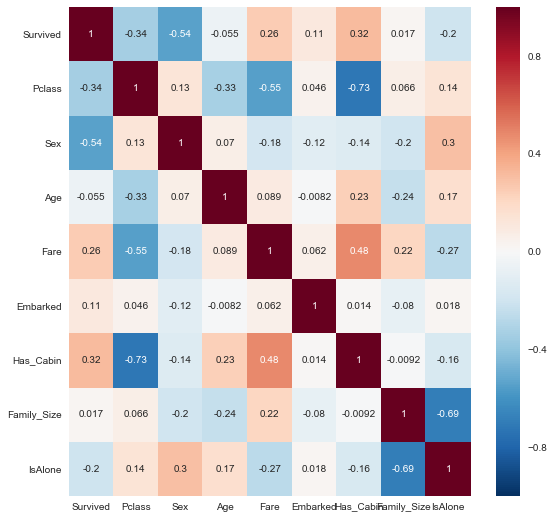

In [44]:
plt.figure(figsize=(9, 9))
sns.heatmap(train.astype(float).corr(), annot=True)

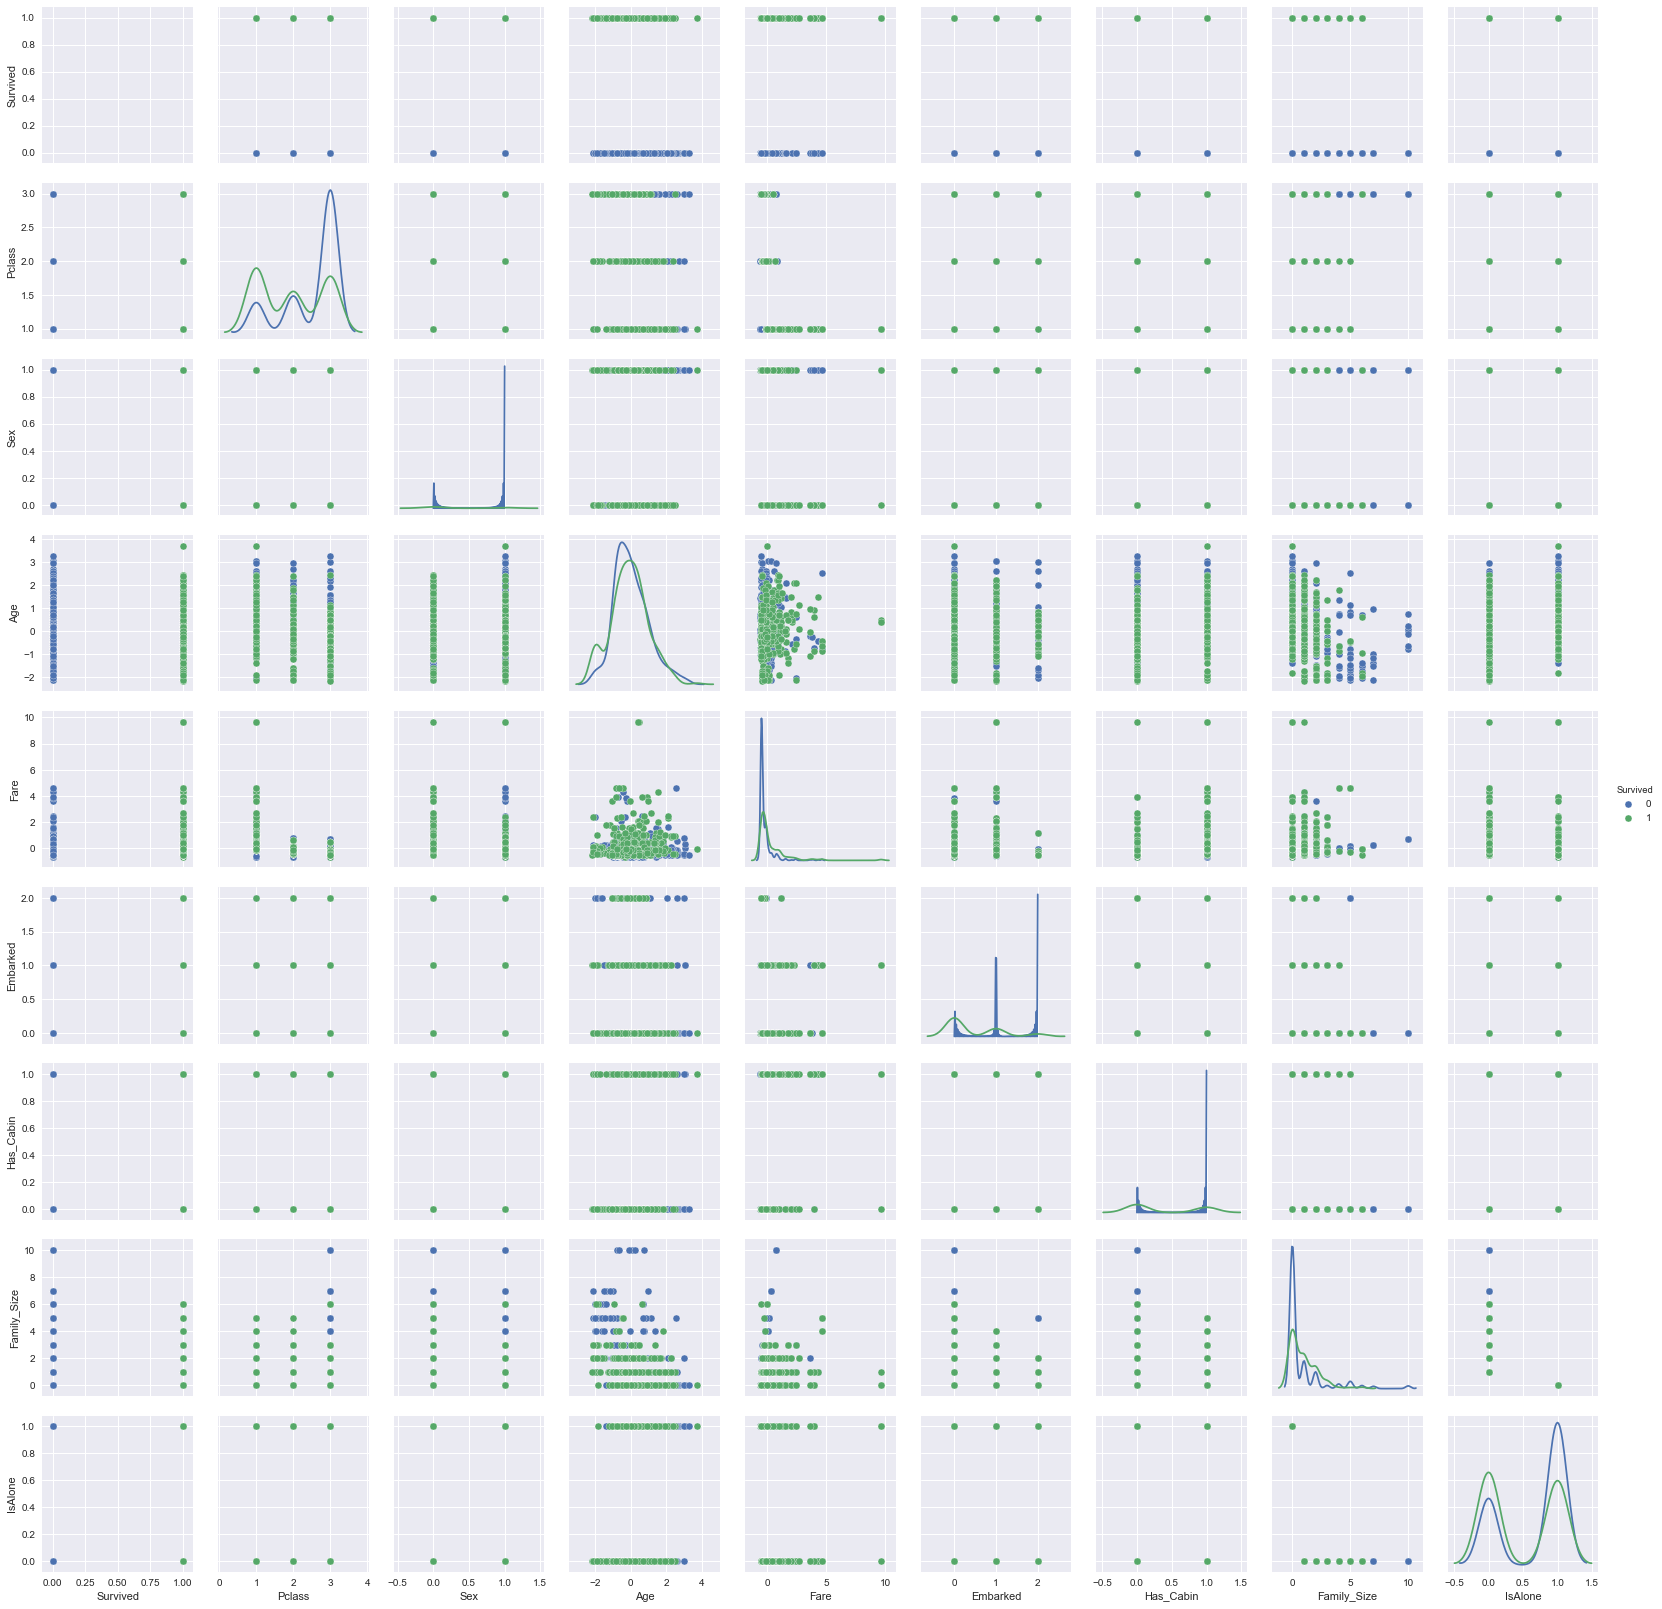

In [45]:
sns.pairplot(train, hue='Survived', diag_kind='kde')

In [46]:
def cm_plot(y, yp):
    cm = confusion_matrix(y, yp)

    import matplotlib.pyplot as plt
    plt.matshow(cm, cmap=plt.cm.Greens)
    plt.colorbar()

    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(
                cm[x, y],
                xy=(x, y),
                horizontalalignment='center',
                verticalalignment='center',
                size=15)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [47]:
x_train = train.drop(['Survived'], axis=1)
y_train = train.Survived
x_test = test
y_test = y_test.Survived

In [48]:
NTRAIN = train.shape[0]
NTEST = test.shape[0]
SEED = 0
NFOLDS = 5


class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x, y)

    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)

In [49]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 10,
    'max_features': 4,
    'min_samples_leaf': 2,
    'bootstrap': True,
    'oob_score': True,
    'verbose': 0
}

rf = SklearnHelper(RandomForestClassifier, SEED, rf_params)
rf.fit(x_train, y_train)
# cm_plot(y_train, rf.predict(x_train))
# cm_plot(y_test, rf.predict(x_test))
# print(rf.fit(x_train, y_train).oob_score_)
cm = confusion_matrix(y_test, rf.fit(x_train,
                                     y_train).predict(x_test)).astype(float)
print(cm[0][1] / cm[0][0], cm[1][0] / cm[1][1])
# print(np.sqrt((cm[0][1] / cm[0][0])**2 + (cm[1][0] / cm[1][1])**2))

(0.068273092369477914, 0.16923076923076924)


In [50]:
ada_params = {'n_estimators': 500, 'learning_rate': 0.7}

ada = SklearnHelper(AdaBoostClassifier, SEED, ada_params)
ada.fit(x_train, y_train)
# cm_plot(y_train, ada.fit(x_train, y_train).predict(x_train))
# cm_plot(y_test, ada.fit(x_train, y_train).predict(x_test))
cm = confusion_matrix(y_test, ada.fit(x_train,
                                      y_train).predict(x_test)).astype(float)
print(cm[0][1] / cm[0][0], cm[1][0] / cm[1][1])
# print(np.sqrt((cm[0][1] / cm[0][0])**2 + (cm[1][0] / cm[1][1])**2))

(0.094650205761316872, 0.256198347107438)


In [51]:
gb_params = {
    'learning_rate': 0.005,
    'n_estimators': 300,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'max_features': 6,
    'verbose': 0
}

gb = SklearnHelper(GradientBoostingClassifier, SEED, gb_params)
gb.fit(x_train, y_train)
cm = confusion_matrix(y_test, gb.fit(x_train,
                                     y_train).predict(x_test)).astype(float)
print(cm[0][1] / cm[0][0], cm[1][0] / cm[1][1])
# print(np.sqrt((cm[0][1] / cm[0][0])**2 + (cm[1][0] / cm[1][1])**2))

(0.051383399209486168, 0.19685039370078741)


In [52]:
svc_params = {'kernel': 'linear', 'C': 0.025}

svc = SklearnHelper(SVC, SEED, svc_params)
svc.fit(x_train, y_train)
cm = confusion_matrix(y_test, svc.fit(x_train,
                                      y_train).predict(x_test)).astype(float)
print(cm[0][1] / cm[0][0], cm[1][0] / cm[1][1])
# print(np.sqrt((cm[0][1] / cm[0][0])**2 + (cm[1][0] / cm[1][1])**2))

(0.0, 0.027027027027027029)


In [53]:
kf = KFold(NTRAIN, n_folds=NFOLDS, random_state=SEED)


# stacking
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((NTRAIN, ))
    oof_test = np.zeros((NTEST, ))
    oof_test_skf = np.empty((NFOLDS, NTEST))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]  #单次训练集x
        y_tr = y_train[train_index]  #单次训练集y
        x_te = x_train[test_index]  #单次测试集x

        clf.train(x_tr, y_tr)  #单次模型训练

        oof_train[test_index] = clf.predict(x_te)  #单次模型对单次测试集(1/N train)预测
        oof_test_skf[i, :] = clf.predict(x_test)  #单次模型对整体测试集(test)预测y_pred

    oof_test[:] = oof_test_skf.mean(axis=0)  #y_pred取平均
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [54]:
rf_oof_train, rf_oof_test = get_oof(rf, x_train.values, y_train, x_test.values)
ada_oof_train, ada_oof_test = get_oof(ada, x_train.values, y_train,
                                      x_test.values)
gb_oof_train, gb_oof_test = get_oof(gb, x_train.values, y_train, x_test.values)
svc_oof_train, svc_oof_test = get_oof(svc, x_train.values, y_train,
                                      x_test.values)

In [55]:
rf_feature = rf.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[ 0.09749592  0.36280524  0.19253124  0.19412499  0.0296966   0.04995009
  0.0638818   0.00951411]
[ 0.004  0.022  0.242  0.684  0.014  0.006  0.026  0.002]
[ 0.10771481  0.42654607  0.15336893  0.17326346  0.01359334  0.05241028
  0.07182241  0.00128069]


In [56]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(),
    'SVC': svc_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel()
})
base_predictions_train.head()

,AdaBoost,GradientBoost,RandomForest,SVC
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [57]:
x_train = np.concatenate(
    (rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(
    (rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

<bound method XGBClassifier.score of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.9, learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=2000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)>
(0.051383399209486168, 0.15151515151515152)


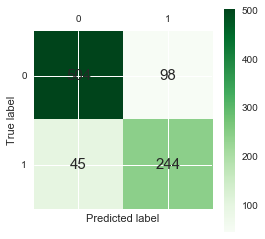

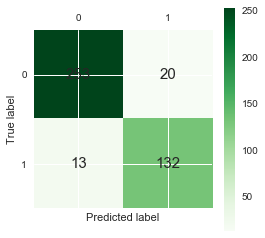

In [58]:
#第二层训练用第一层训练每次预测结果的集合做x_train,用总预测结果的均值做x_pred
#即用第一层的结果矩阵做x_train，总预测结果的均值做x_pred
gbm = xgb.XGBClassifier(
    learning_rate=0.01,
    n_estimators=2000,
    max_depth=6,
    min_child_weight=1,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=SEED).fit(x_train, y_train)

predictions = gbm.predict(x_test)

cm_plot(y_train, gbm.predict(x_train))
cm_plot(y_test, gbm.predict(x_test))
print(gbm.score)

cm = confusion_matrix(y_test, predictions).astype(float)
print(cm[0][1] / cm[0][0], cm[1][0] / cm[1][1])

In [59]:
def modelfit(alg,
             dtrain,
             predictors,
             useTrainCV=True,
             cv_folds=5,
             early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        print(xgb_param)
        xgtrain = xgb.DMatrix(
            dtrain[predictors].values, label=dtrain[target].values)

        cvresult = xgb.cv(
            xgb_param,
            xgtrain,
            num_boost_round=alg.get_params()['n_estimators'],
            nfold=cv_folds,
            metrics='auc',
            early_stopping_rounds=early_stopping_rounds,
            seed=SEED,
            verbose_eval=True)
        #         print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(dtrain[predictors], dtrain['Survived'], eval_metric='auc')

    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]

    print "\nModel Report"
    print "Accuracy : %.4g" % sklearn.metrics.accuracy_score(
        dtrain['Survived'], dtrain_predictions)
    print "AUC Score (Train): %f" % sklearn.metrics.roc_auc_score(
        dtrain['Survived'], dtrain_predprob)

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(
        ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

{'reg_alpha': 0, 'colsample_bytree': 0.8, 'silent': 1, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'missing': None, 'max_delta_step': 0, 'base_score': 0.5, 'n_estimators': 2000, 'subsample': 0.8, 'reg_lambda': 1, 'seed': 0, 'min_child_weight': 1, 'objective': 'binary:logistic', 'max_depth': 6, 'gamma': 0.9}
[0]	train-auc:0.858186+0.00386281	test-auc:0.83968+0.0321814
[1]	train-auc:0.878042+0.0125195	test-auc:0.849983+0.0280278
[2]	train-auc:0.885559+0.0106281	test-auc:0.859113+0.0267733
[3]	train-auc:0.89272+0.0121648	test-auc:0.861289+0.0280609
[4]	train-auc:0.896572+0.0101611	test-auc:0.86106+0.029589
[5]	train-auc:0.897172+0.0129252	test-auc:0.862028+0.0273662
[6]	train-auc:0.900204+0.0116255	test-auc:0.863917+0.0313294
[7]	train-auc:0.902417+0.01106	test-auc:0.863595+0.0329764
[8]	train-auc:0.903625+0.00990946	test-auc:0.864719+0.031364
[9]	train-auc:0.905281+0.00872473	test-auc:0.864573+0.0299141
[10]	train-auc:0.905844+0.00961985	test-auc:0.863647+0.0308

[126]	train-auc:0.926743+0.00464453	test-auc:0.872291+0.0320763
[127]	train-auc:0.926847+0.00459601	test-auc:0.87243+0.0320505
[128]	train-auc:0.927+0.0045919	test-auc:0.872436+0.0320081
[129]	train-auc:0.9273+0.00452905	test-auc:0.872279+0.0318102
[130]	train-auc:0.927416+0.00456559	test-auc:0.872352+0.0316583
[131]	train-auc:0.927515+0.00456433	test-auc:0.87237+0.0317726
[132]	train-auc:0.927667+0.00460669	test-auc:0.872613+0.031551
[133]	train-auc:0.927873+0.00462367	test-auc:0.872701+0.0317666
[134]	train-auc:0.92797+0.00454438	test-auc:0.872674+0.0316854
[135]	train-auc:0.928088+0.00443273	test-auc:0.873216+0.0318832
[136]	train-auc:0.928241+0.00448231	test-auc:0.873079+0.0317582
[137]	train-auc:0.928437+0.00442864	test-auc:0.873183+0.0318975
[138]	train-auc:0.928559+0.00443998	test-auc:0.873285+0.0319471
[139]	train-auc:0.928796+0.00455918	test-auc:0.873234+0.0317155
[140]	train-auc:0.928845+0.00457992	test-auc:0.873154+0.031791
[141]	train-auc:0.92896+0.00460806	test-auc:0.87316

[255]	train-auc:0.942708+0.00472879	test-auc:0.876592+0.0304578
[256]	train-auc:0.942805+0.00471589	test-auc:0.876562+0.0303208
[257]	train-auc:0.94286+0.00472944	test-auc:0.87661+0.030457
[258]	train-auc:0.942904+0.00464964	test-auc:0.876689+0.0304815
[259]	train-auc:0.943031+0.00460722	test-auc:0.876769+0.030503
[260]	train-auc:0.943098+0.00465835	test-auc:0.876798+0.0304406
[261]	train-auc:0.943181+0.00462282	test-auc:0.876769+0.0305595
[262]	train-auc:0.943309+0.00465473	test-auc:0.876871+0.0302481
[263]	train-auc:0.943383+0.00475123	test-auc:0.876876+0.0301591
[264]	train-auc:0.943508+0.00474873	test-auc:0.876845+0.030261
[265]	train-auc:0.943617+0.00478039	test-auc:0.876896+0.0301798
[266]	train-auc:0.943723+0.00474151	test-auc:0.876928+0.0302197
[267]	train-auc:0.943769+0.004686	test-auc:0.876924+0.0303509
[268]	train-auc:0.94383+0.00473644	test-auc:0.87701+0.0302806
[269]	train-auc:0.943803+0.00468763	test-auc:0.876952+0.030313
[270]	train-auc:0.943868+0.00476314	test-auc:0.877

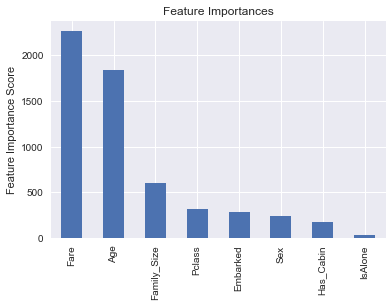

In [60]:
target = 'Survived'
IDcol = 'PassagerId'
predictors = [x for x in train.columns if x not in [target, IDcol]]
modelfit(gbm, train, predictors)

In [61]:
#影响比较大的参数
param_test1 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}

gsearch1 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.01,
        n_estimators=320,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=SEED),
    param_grid=param_test1,
    scoring='roc_auc',
    n_jobs=4,
    iid=False,
    cv=5)

gsearch1.fit(train[predictors], train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.86901, std: 0.03380, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.86892, std: 0.02848, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.86942, std: 0.02635, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.86981, std: 0.03584, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.86789, std: 0.03362, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.86998, std: 0.02987, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.86971, std: 0.03675, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.86853, std: 0.03367, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.87191, std: 0.03098, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.87001, std: 0.03670, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.86840, std: 0.03369, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.87188, std: 0.03099, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 5